In [235]:
#bhv_train.csv，训练集数据，包含脱敏后的客户行为数据。
#cust_train.csv，训练集数据，脱敏后的客户基本情况信息。
#train_label.csv，训练集数据，包含脱敏后的客户ID（客户唯一识别号）和相应label（标签）。
#loan_train.csv，训练集数据，脱敏后的客户贷款数据。
#trans_train.csv，训练集数据，脱敏后的客户交易信息。
#asset_train.csv，训练集数据，脱敏后的客户资产信息。
import warnings
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
warnings.simplefilter('ignore')
# 读取训练数据
ass_train = pd.read_csv('../input/赛题A_预赛数据/训练集/asset_train.csv')
bhv_train = pd.read_csv('../input/赛题A_预赛数据/训练集/bhv_train.csv')
cust_train = pd.read_csv('../input/赛题A_预赛数据/训练集/cust_train.csv')
train_label = pd.read_csv('../input/赛题A_预赛数据/训练集/train_label.csv')
loan_train = pd.read_csv('../input/赛题A_预赛数据/训练集/loan_train.csv')
trans_train = pd.read_csv('../input/赛题A_预赛数据/训练集/trans_train.csv')

ass_test = pd.read_csv('../input/赛题A_预赛数据/测试集/asset_test.csv')
bhv_test = pd.read_csv('../input/赛题A_预赛数据/测试集/bhv_test.csv')
cust_test = pd.read_csv('../input/赛题A_预赛数据/测试集/cust_test.csv')
loan_test = pd.read_csv('../input/赛题A_预赛数据/测试集/loan_test.csv')
trans_test = pd.read_csv('../input/赛题A_预赛数据/测试集/trans_test.csv')

In [236]:
train = cust_train.merge(train_label, on = 'id', how = 'left')
train = train.merge(ass_train, on = 'id', how = 'left')
train = train.merge(bhv_train, on = 'id', how = 'left')
train = train.merge(loan_train, on = 'id', how = 'left')
train = train.merge(trans_train, on = 'id', how = 'left')

test = cust_test.merge(ass_test, on = 'id', how = 'left')
test = test.merge(bhv_test, on = 'id', how = 'left')
test = test.merge(loan_test, on = 'id', how = 'left')
test = test.merge(trans_test, on = 'id', how = 'left')

data = train.append(test).reset_index(drop=True)
print(test.shape)
print(data['label'].isna().sum())

(3600, 55)
3600


In [218]:
# def f1(x):
#     return int(str(x)[:4])
# def f2(x):
#     return int(str(x)[4:6])
# data['a20'] = data['a20'].fillna(100000.0) 
# data['a21'] = data['a21'].fillna(100000.0) 
# data['loan_gap'] = data['a21'] - data['a20']
# data['a20_year'] = data['a20'].apply(f1)
# data['a20_month'] = data['a20'].apply(f2)
# data['a21_year'] = data['a21'].apply(f1)
# data['a21_year'] = data['a21'].apply(f2)

In [237]:
#data['loan_gap'] = data['a21'] - data['a20']
#data['last_money_save'] = data['a28'] - data['a29']
#data['money_save'] = data['a32'] - data['a33']
#data['s_ratio'] = data['a34'] / (data['a30']+1e-5)
#data['g_ratio'] = data['a35'] / (data['a31']+1e-5)

In [238]:
# data.loc[data['a28'] <= data['a29'],'f28_29_mark'] = 0
# data.loc[data['a28'] > data['a29'],'f28_29_mark'] = 1
# data.loc[data['a32'] <= data['a33'],'f32_33_mark'] = 0
# data.loc[data['a32'] > data['a33'],'f32_33_mark'] = 1

In [239]:
drop_cols = ['id','label']
for f in data.columns:
    if data[f].nunique() < 2:
        drop_cols.append(f)
    if data[~data[f].isna()][f].value_counts().values[0] / data[~data[f].isna()].shape[0] > 0.99:
        drop_cols.append(f)

In [240]:
cat_f = ['a1','a4']
for f in cat_f:
    data[f] = data[f].astype(str)
    le = LabelEncoder()
    data[f] = le.fit_transform(data[f])
data.head()

,id,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a27,a28,a29,a30,a31,a32,a33,a34,a35,loan_gap
0,532032d9e16e123c4885236cf1fc2d1e,2,67.0,4.0,5,0,0,0.0,1,0,...,0.0,0.0000,0.0,0,0,0.00,0.0,0,0,NaN
1,3fcdc734dc2fefa8acb0bf4f48e8fcf4,2,3.0,4.0,5,0,0,0.0,0,0,...,0.0,0.0000,0.0,0,0,0.00,0.0,0,0,NaN
2,02ec6569f2679be5dfc3d075a1ccf87b,2,2.0,5.0,5,0,0,0.0,4,0,...,0.0,9971.6208,9500.0,2,1,177.56,0.0,1,0,NaN
3,888c49cb3235fa8eaede9ad4c68aa6a1,1,70.0,1.0,5,0,0,0.0,4,0,...,0.0,0.0000,0.0,0,0,103500.00,94500.0,1,1,NaN
4,9994690c6eb5faa7805944d5de3e69bc,1,8.0,6.0,5,0,0,0.0,0,0,...,0.0,0.0000,0.0,0,0,0.00,0.0,0,0,NaN


In [241]:
test_df = data[data["label"].isnull() == True].copy().reset_index(drop=True)
train_df = data[~data["label"].isnull() == True].copy().reset_index(drop=True)

In [242]:
feature_name = [f for f in data.columns if f not in drop_cols]

In [243]:
X_train = train_df[feature_name].reset_index(drop=True)
X_test = test_df[feature_name].reset_index(drop=True)
y = train_df['label'].reset_index(drop=True)
print(len(feature_name))
print(feature_name)

50
['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a13', 'a14', 'a16', 'a17', 'a49', 'a50', 'a51', 'a52', 'a53', 'a54', 'a38', 'a40', 'a41', 'a42', 'a43', 'a44', 'a45', 'a46', 'a47', 'a48', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32', 'a33', 'a34', 'a35', 'loan_gap']


In [244]:
train_pred = {}
test_pred = {}

In [245]:
# seeds = [2222, 5, 4, 2, 209, 4096, 2048, 1024, 2015, 1015, 820]#11
seeds = [2]#2
num_model_seed = 1
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
parameters = {
    'learning_rate': 0.008,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 63,
    'feature_fraction': 0.8,#原来0.8
    'bagging_fraction': 0.8,
    'bagging_freq': 5,#5
    'seed': 2,
    'bagging_seed': 1,
    'feature_fraction_seed': 7,
    'min_data_in_leaf': 20,
    'verbose': -1, 
    'n_jobs':8
}
fold = 5
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(test_x, label=test_y)
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dval],
            early_stopping_rounds=100,
            verbose_eval=100, )
        oof_cat[test_index] += lgb_model.predict(test_x,num_iteration=lgb_model.best_iteration)
        prediction_cat += lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration) / fold
        feat_imp_df['imp'] += lgb_model.feature_importance()

        del train_x
        del test_x
        del train_y
        del test_y
        del lgb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
gc.collect()

2 --------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.876655
[200]	valid_0's auc: 0.875706
Early stopping, best iteration is:
[118]	valid_0's auc: 0.87725
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.891294
[200]	valid_0's auc: 0.894749
[300]	valid_0's auc: 0.892049
Early stopping, best iteration is:
[201]	valid_0's auc: 0.89481
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.907669
[200]	valid_0's auc: 0.909585
Early stopping, best iteration is:
[155]	valid_0's auc: 0.90999
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.883069
Early stopping, best iteration is:
[68]	valid_0's auc: 0.884002
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.881156
[200]	valid_0's auc: 0.881527
Early stopping, best iteration is:
[123

3131

In [246]:
print(feat_imp_df.sort_values('imp', ascending=False))

       feats   imp
1         a2  3076
2         a3  2776
15       a49  2450
16       a50  2289
17       a51  2150
7         a8  2045
20       a54  2041
18       a52  1992
46       a33  1985
38       a25  1820
3         a4  1790
41       a28  1729
45       a32  1716
19       a53  1686
42       a29  1549
29       a47  1086
44       a31  1058
0         a1   835
48       a35   833
47       a34   755
43       a30   515
6         a7   424
40       a27   407
9        a10   406
39       a26   383
28       a46   354
34       a21   315
37       a24   276
33       a20   268
30       a48   253
23       a41   247
36       a23   168
22       a40   155
26       a44   153
25       a43   139
27       a45   138
35       a22   137
32       a19   130
4         a5   123
10       a11   117
21       a38   113
5         a6   105
24       a42    77
49  loan_gap    70
12       a14    34
13       a16    33
31       a18    12
14       a17     7
11       a13     7
8         a9     3


In [247]:
train_pred['lgb'] = oof
test_pred['lgb'] = prediction

In [248]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
print("lgb train auc: ", roc_auc_score(y, train_pred['lgb']))

lgb train auc:  0.883565921606738


In [249]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.1,0.9,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (train_pred['lgb'].reshape((-1)) > threshold).astype('int')
    m = f1_score(y.values.reshape((-1)), preds, average='binary')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 

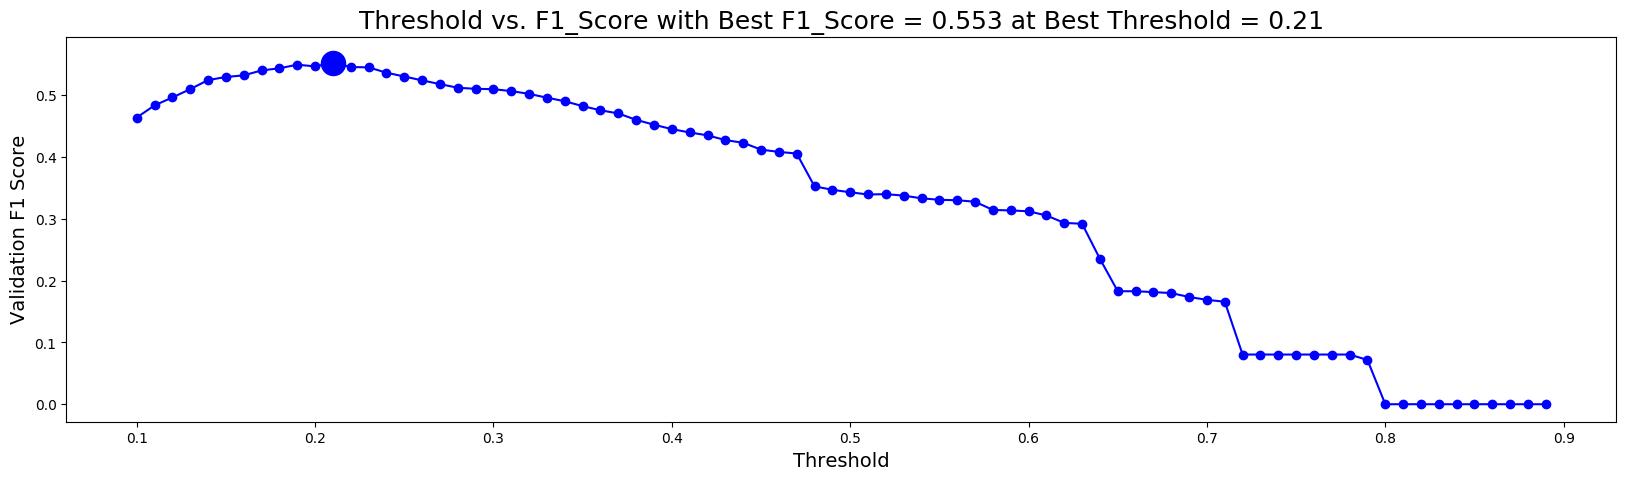

In [250]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [251]:
auc = roc_auc_score(y, train_pred['lgb'])
f1 = best_score
print(auc*0.3 + f1*0.7)

0.652128600011433


In [252]:
label=[1 if x >= best_threshold else 0 for x in prediction]
np.sum(label)

512

In [253]:
sub = test[['id']]
sub['pred_prob'] = prediction
sub['pred_label'] = label
sub.head()

,id,pred_prob,pred_label
0,9bb9cdf5c620d3e544ecc40c323891e7,0.060198,0
1,4df9fa2db089bfdfd3c0f6fb480d7081,0.222807,1
2,f700afd6a245cd5deadd7d23ae91bc76,0.055288,0
3,4ee4f29b6bdacb6432175fe1a695580b,0.051162,0
4,bda4cef7762b3fb7531f426659c8a160,0.134847,0


In [254]:
sub.to_csv('/home/workspace/output/submit.csv',index=0)

In [255]:
! castlecli --third local --token a37c1570991261a30b300c4d69dd8dff --source /home/workspace/output/submit.csv



     ▄████▄  ▄▄▄       ██████▄▄▄█████▓██▓   ▓█████ 
    ▒██▀ ▀█ ▒████▄   ▒██    ▒▓  ██▒ ▓▓██▒   ▓█   ▀ 
    ▒▓█    ▄▒██  ▀█▄ ░ ▓██▄  ▒ ▓██░ ▒▒██░   ▒███   
    ▒▓▓▄ ▄██░██▄▄▄▄██  ▒   ██░ ▓██▓ ░▒██░   ▒▓█  ▄ 
    ▒ ▓███▀ ░▓█   ▓██▒██████▒▒ ▒██▒ ░░██████░▒████▒
    ░ ░▒ ▒  ░▒▒   ▓▒█▒ ▒▓▒ ▒ ░ ▒ ░░  ░ ▒░▓  ░░ ▒░ ░
      ░  ▒    ▒   ▒▒ ░ ░▒  ░ ░   ░   ░ ░ ▒  ░░ ░  ░
    ░         ░   ▒  ░  ░  ░   ░       ░ ░     ░   
    ░ ░           ░  ░     ░             ░  ░  ░  ░
    ░                                              

    
〔 版本状态 〕 v0.14 
〔 校验权限 〕 有效 
〔 竞赛信息 〕 赛道A：个人消费贷款申贷客户识别 
〔 用户信息 〕 是小泽 
〔 提交备注 〕  
〔 文件分段 〕 [1]段 
〔 上传进度 〕 [##################################################]100%        1/1
〔 资源标识 〕 00000187F0F1B97B84CC35CABDEF7FD5 
〔 提交状态 〕 成功 

